<h1>WEB TRAFFIC TIME SERIES FORECASTING:-</h1>



<h1>Problem Statement and Description</h1>
<h3>1.The problemstatement is about forecasing future web traffic for 145k wikipedia article.<br>
2.dataset has 145k time series data on the views of different wikipedia pages,starting from July, 1st, 2015 up until December 31st, 2016.each row in the dataset is time series of daily page view of a specific article.For each time series the name of article is given along with some additional data are given such as  type of traffic that this time series represent (all, mobile, desktop, spider),language etc.

<h1>ML problem<h1>
<h3>1.basically the problem statement can be thought of as a regrssion problem.

<h1>EVALUATION MATRICS:-</h1>
<h3>1.SMAPE:-the evaluation metrics used in the problem statement is SMAPE(Symmetric mean absolute percentage error).it is the absolute difference between forecast value and actual value divided by half of sum of absolute values of forecast and actual value.this value again divided by number of data point multiplied by 100.<br>
reference: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

<h1>EDA</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
%pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle competitions download -c web-traffic-time-series-forecasting

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import seaborn as sns
from random import randint

In [ ]:
data=pd.read_csv("/content/gdrive/My Drive/Kaggle/train_2.csv.zip").fillna(0)
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [ ]:
print("shape of the dataset is",data.shape)

shape of the dataset is (145063, 804)


In [ ]:
new_data=data.copy()
pages=data["Page"]

In [ ]:
len(pages)

145063

In [ ]:
#this chunk of code extract the project,access and agent type from the page information given in the data set
project=[]
access=[]
agent=[]
language=[]
for i in range(len(pages)):
  temp=pages[i].split(".")
  project.append(temp[-2])
  k=temp[-3].split("_")
  language.append(k[-1])
  t=temp[-1].split("_")
  access.append(t[1])
  agent.append(t[2])

In [ ]:
new_data["project"]=project
new_data["access"]=access
new_data["agent"]=agent
new_data["language"]=language

In [ ]:
new_data.shape

(145063, 808)

In [ ]:
new_data.head(2)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,project,access,agent,language
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0,wikipedia,all-access,spider,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0,wikipedia,all-access,spider,zh


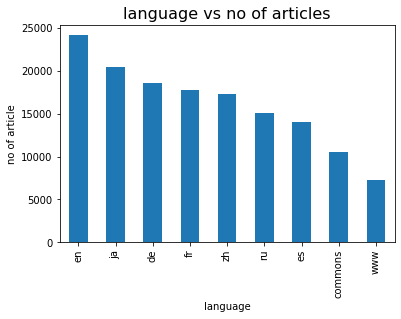

In [ ]:
language_count=new_data["language"].value_counts()
language_count.plot.bar()
plt.xlabel("language")
plt.ylabel("no of article")
plt.title("language vs no of articles",fontsize=16)
plt.show()

**obervations:-**
1.english language has higher number of wiki pages.

2.www language has the least number of wiki pages

In [ ]:
#creating dictionary for every language and pages.
all_language=language_count.keys()
language={}
language["en"]=data[new_data.language=="en"].iloc[:,:]
language["ja"]=data[new_data.language=="ja"].iloc[:,:]
language["de"]=data[new_data.language=="de"].iloc[:,:]
language["fr"]=data[new_data.language=="fr"].iloc[:,:]
language["zh"]=data[new_data.language=="zh"].iloc[:,:]
language["ru"]=data[new_data.language=="ru"].iloc[:,:]
language["es"]=data[new_data.language=="es"].iloc[:,:]
language["commons"]=data[new_data.language=="commons"].iloc[:,:]
language["www"]=data[new_data.language=="www"].iloc[:,:]

In [ ]:
#calculating mean of every language daywise
everyday_mean={}
for i in all_language:
  everyday_mean[i]=language[i].iloc[:,1:].sum(axis=0)/language[i].shape[0]

In [ ]:
everyday_mean["en"][0:5]

2015-07-01    3513.862203
2015-07-02    3502.511407
2015-07-03    3325.357889
2015-07-04    3462.054256
2015-07-05    3575.520035
dtype: float64

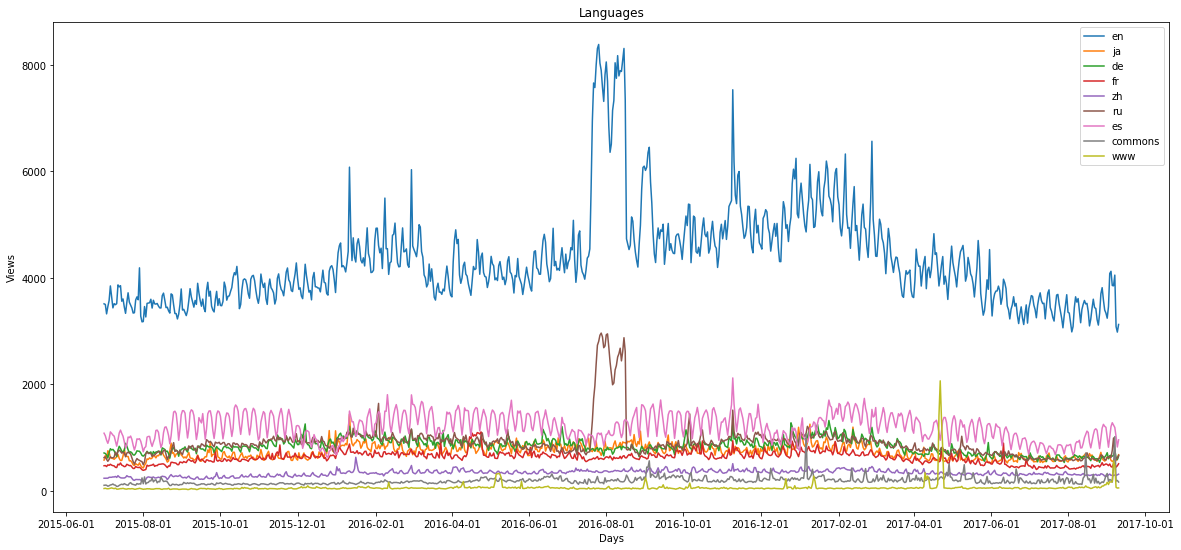

In [ ]:
day=[i for i in everyday_mean["en"].keys()]
days=[dt.datetime.strptime(d,"%Y-%m-%d").date() for d in day]
fig = plt.figure(1,figsize=[20,10])
plt.ylabel('Views')
plt.xlabel('Days')
plt.title('Languages')
plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
for i in everyday_mean:
  plt.plot(days,everyday_mean[i],label=i)
plt.legend()
plt.show()

**obervations:-**
1.form the above chart it can be seen that english language wiki pages have higher traffic than all other language.

2.spanish language has the second highest everyday mean page visit.

3.around aug of 2016 there is spike in visit for russian pages and english pages.

4.spanish page is very much periodic in nature .

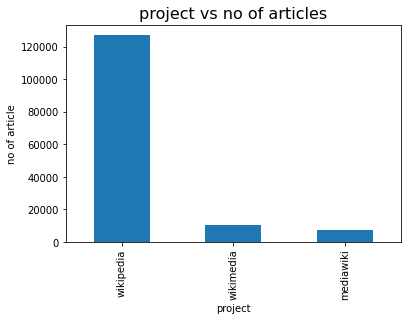

In [ ]:
project_count=new_data["project"].value_counts()
project_count.plot.bar()
plt.xlabel("project")
plt.ylabel("no of article")
plt.title("project vs no of articles",fontsize=16)
plt.show()

**obervation:-**
1.more number of wikipedia pages are given which means more traffic on wikipedia pages.

2.wikimedia pages and mediawiki pages have less number of traffic.

In [ ]:
#creating dictionary for project type and pages.
all_project=project_count.keys()
project={}
project["wikipedia"]=data[new_data.project=="wikipedia"].iloc[:,:]
project["wikimedia"]=data[new_data.project=="wikimedia"].iloc[:,:]
project["mediawiki"]=data[new_data.project=="mediawiki"].iloc[:,:]

In [ ]:
#calculating mean of accesstype daywise
everyday_mean_project={}
for i in all_project:
  everyday_mean_project[i]=project[i].iloc[:,1:].sum(axis=0)/project[i].shape[0]

In [ ]:
everyday_mean_project["wikipedia"][0:5]

2015-07-01    1157.017971
2015-07-02    1163.700632
2015-07-03    1098.106542
2015-07-04    1134.778190
2015-07-05    1179.948203
dtype: float64

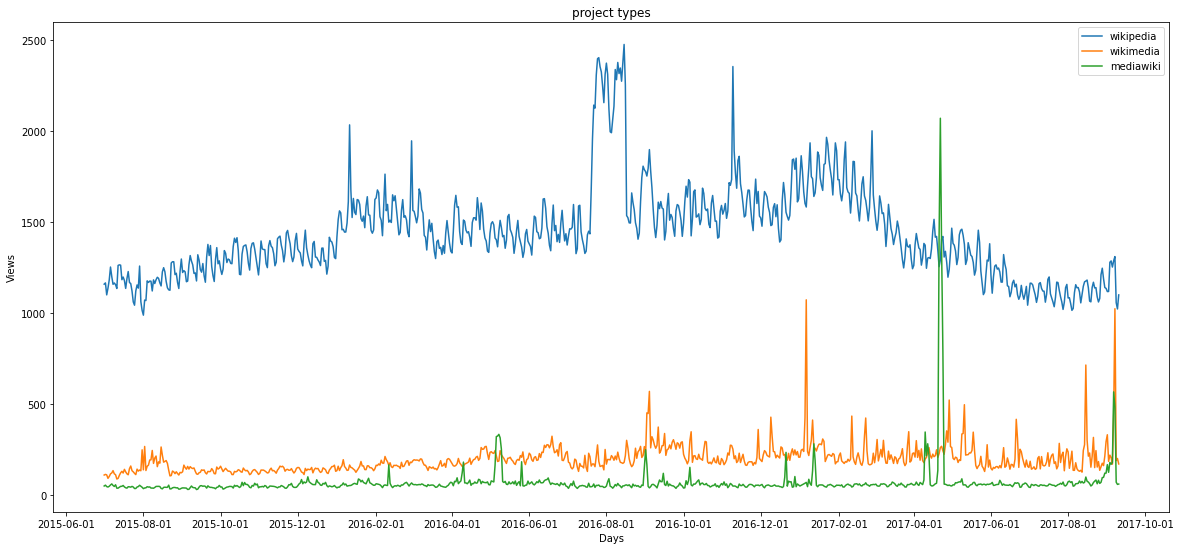

In [ ]:
day=[i for i in everyday_mean_project["wikipedia"].keys()]
days=[dt.datetime.strptime(d,"%Y-%m-%d").date() for d in day]
fig = plt.figure(1,figsize=[20,10])
plt.ylabel('Views')
plt.xlabel('Days')
plt.title('project types')
plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
for i in everyday_mean_project:
  plt.plot(days,everyday_mean_project[i],label=i)
plt.legend()
plt.show()

**obervations:-**
1.wikipedia pages has higher mean traffic.the traffic spike that wa seen in language plot was speicfically on wikipedia page other project types didnot contribute to the spike.

2.wikimedia pages got traffic spike in jan 2017 and sep 2017.

3.mediawiki pages has got a unexpectedly high traffic in may 2017.

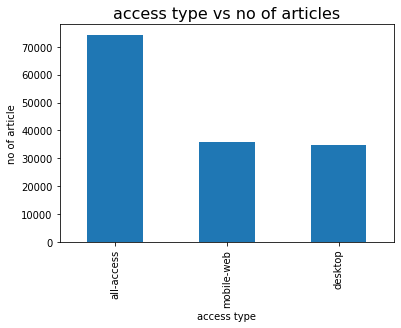

In [ ]:
access_count=new_data["access"].value_counts()
access_count.plot.bar()
plt.xlabel("access type")
plt.ylabel("no of article")
plt.title("access type vs no of articles",fontsize=16)
plt.show()

**obervations:-**
1.all_access type has higher traffic compared to the other two categories of access

2.mobile-web and desktop bar size looks almost smililar but mobile-web has slightly higher traffic.

In [ ]:
#creating dictionary for access type and pages.
all_access=access_count.keys()
access={}
access["all-access"]=data[new_data.access=="all-access"].iloc[:,:]
access["mobile-web"]=data[new_data.access=="mobile-web"].iloc[:,:]
access["desktop"]=data[new_data.access=="desktop"].iloc[:,:]

In [ ]:
#calculating mean of accesstype daywise
everyday_mean_access={}
for i in all_access:
  everyday_mean_access[i]=access[i].iloc[:,1:].sum(axis=0)/access[i].shape[0]

In [ ]:
everyday_mean_access["desktop"][0:5]

2015-07-01    1145.587003
2015-07-02    1153.914993
2015-07-03    1030.652216
2015-07-04     965.274757
2015-07-05    1017.635640
dtype: float64

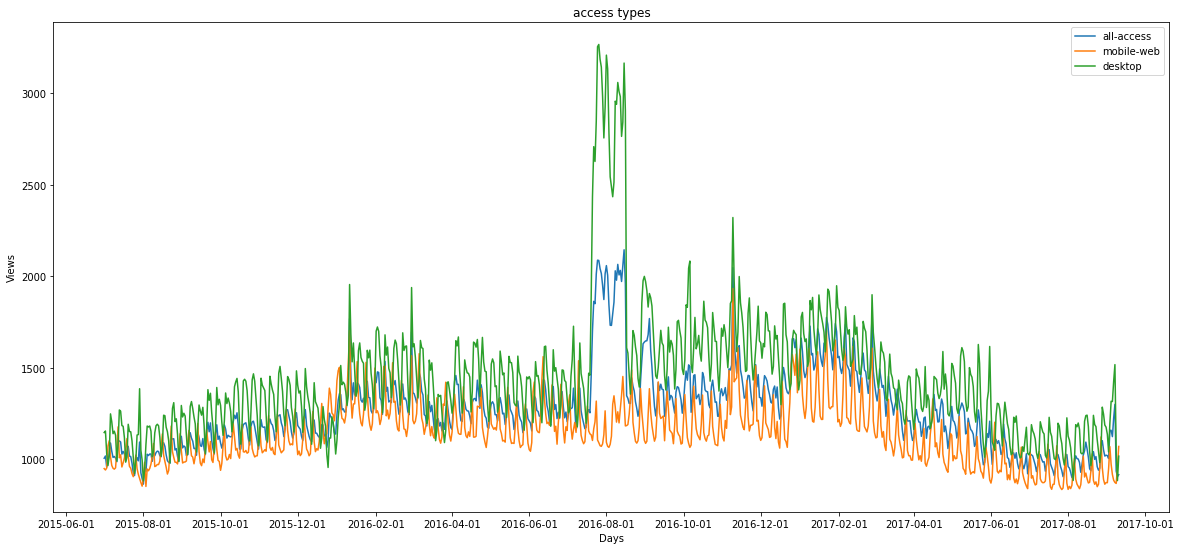

In [ ]:
day=[i for i in everyday_mean_access["desktop"].keys()]
days=[dt.datetime.strptime(d,"%Y-%m-%d").date() for d in day]
fig = plt.figure(1,figsize=[20,10])
plt.ylabel('Views')
plt.xlabel('Days')
plt.title('access types')
plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
for i in everyday_mean_access:
  plt.plot(days,everyday_mean_access[i],label=i)
plt.legend()
plt.show()

**obervations:-**
1.desktop access has the highest mean traffic and mobile web has the lowest mean traffic.
2. sililar trend as language arroung aug 2016 is seen here as well.

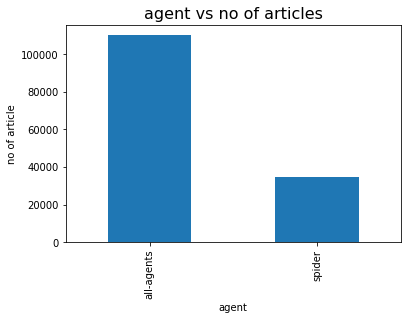

In [ ]:
agent_count=new_data["agent"].value_counts()
agent_count.plot.bar()
plt.xlabel("agent")
plt.ylabel("no of article")
plt.title("agent vs no of articles",fontsize=16)
plt.show()

**obervations:-**
1.all-agent type has higher number of pages than spider agent.

In [ ]:
#creating dictionary for agent type and pages.
all_agent=agent_count.keys()
agent={}
agent["all-agents"]=data[new_data.agent=="all-agents"].iloc[:,:]
agent["spider"]=data[new_data.agent=="spider"].iloc[:,:]

In [ ]:
#calculating mean of agents daywise
everyday_mean_agent={}
for i in all_agent:
  everyday_mean_agent[i]=agent[i].iloc[:,1:].sum(axis=0)/agent[i].shape[0]

In [ ]:
everyday_mean_agent["spider"][0:5]

2015-07-01    19.037264
2015-07-02    17.745539
2015-07-03    17.045284
2015-07-04    17.582591
2015-07-05    17.825566
dtype: float64

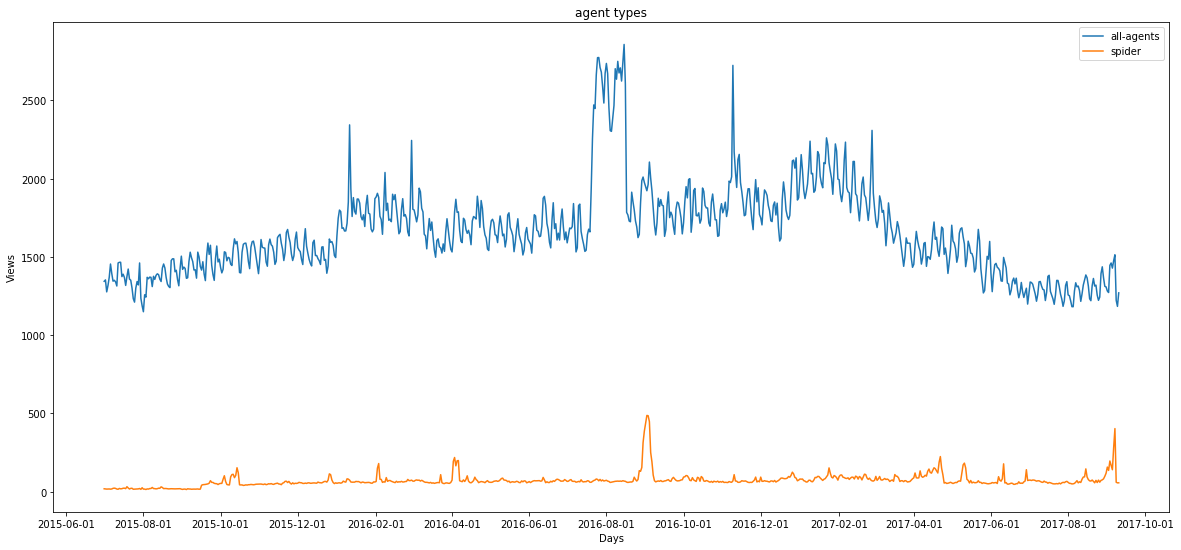

In [ ]:
day=[i for i in everyday_mean_agent["spider"].keys()]
days=[dt.datetime.strptime(d,"%Y-%m-%d").date() for d in day]
fig = plt.figure(1,figsize=[20,10])
plt.ylabel('Views')
plt.xlabel('Days')
plt.title('agent types')
plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
for i in everyday_mean_agent:
  plt.plot(days,everyday_mean_agent[i],label=i)
plt.legend()
plt.show()

**obervations:-**
1.all-agent has higher mean traffic as compared to spider.

**month and year wise analysis**

In [ ]:
df=everyday_mean['en']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df.head()

,date,visit
0,2015-07-01,3513.862203
1,2015-07-02,3502.511407
2,2015-07-03,3325.357889
3,2015-07-04,3462.054256
4,2015-07-05,3575.520035


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,visit,year,month
0,2015-07-01,3513.862203,2015,7
1,2015-07-02,3502.511407,2015,7
2,2015-07-03,3325.357889,2015,7
3,2015-07-04,3462.054256,2015,7
4,2015-07-05,3575.520035,2015,7


Text(0, 0.5, 'visit')

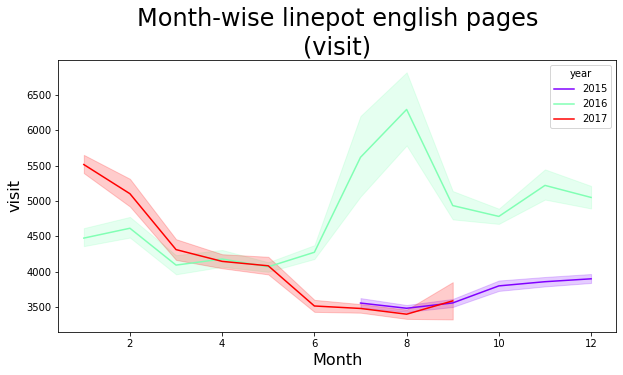

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise linepot english pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.no seasonality is found in all the linplot of avargae page visit month wise.

Text(0, 0.5, 'visit')

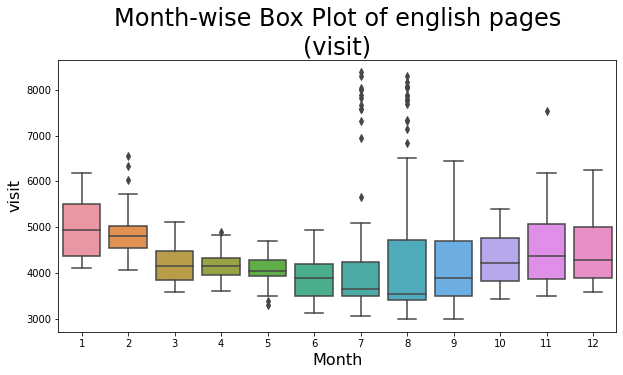

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of english pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.august month has the highest and lowest mean traffic.

2.january month has the highest IQR.

3.july and august month has some unexpected spike or outliers.

Text(0, 0.5, 'visit')

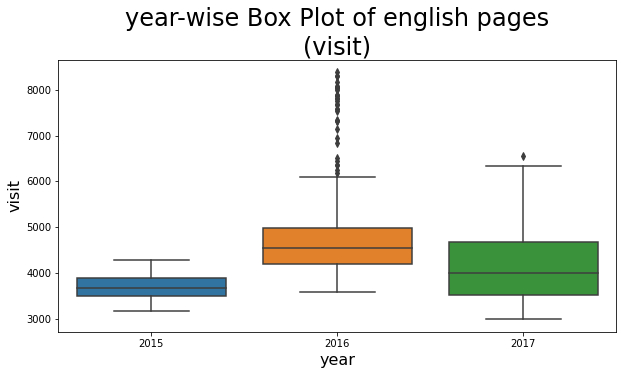

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of english pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2016 has highest page visit and most number of outliers.

2.2017 has the lowest page visit.


Text(0, 0.5, 'visit')

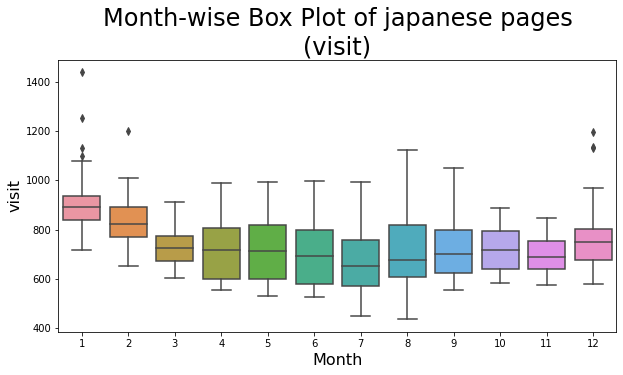

In [ ]:
df=everyday_mean['ja']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of japanese pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.august month has the highest and lowest mean traffic.

2.january month has the highest IQR. and most of the outliers present in january

Text(0, 0.5, 'visit')

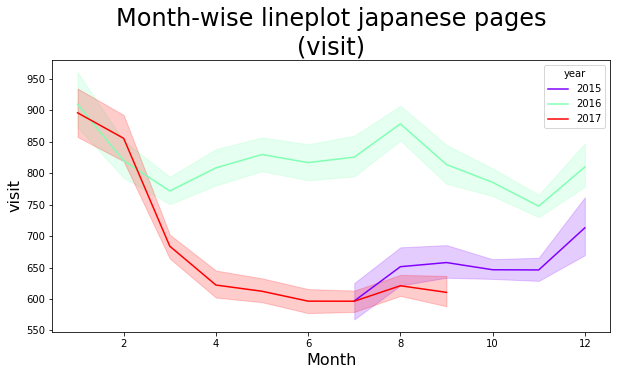

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot japanese pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

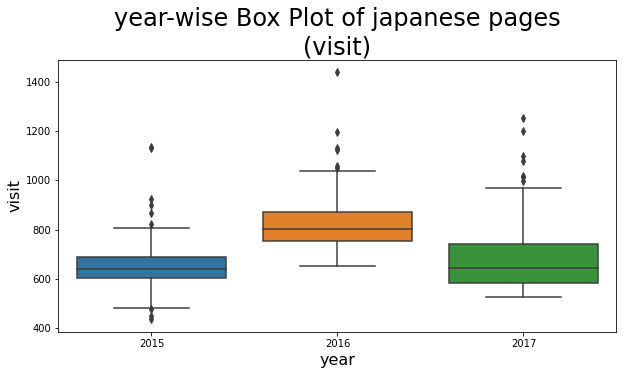

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of japanese pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2016 has the highest per day mean traffic and 2015 has the lowest mean traffic.

Text(0, 0.5, 'visit')

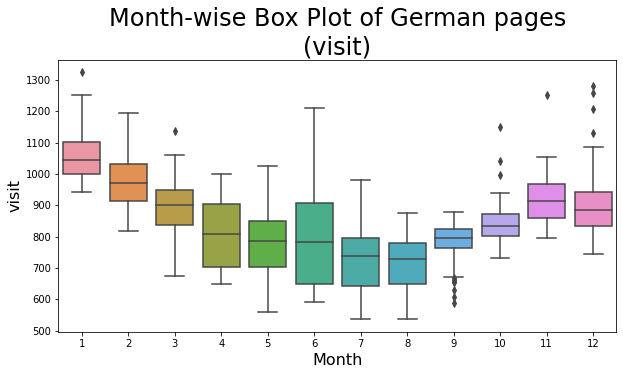

In [ ]:
df=everyday_mean['de']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of German pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.january month has the highest avarage page visit.

2.may has thr lowest avarage page visit.

3.december and october has some unexpected upward spike where as in september 
there is downward spike.

Text(0, 0.5, 'visit')

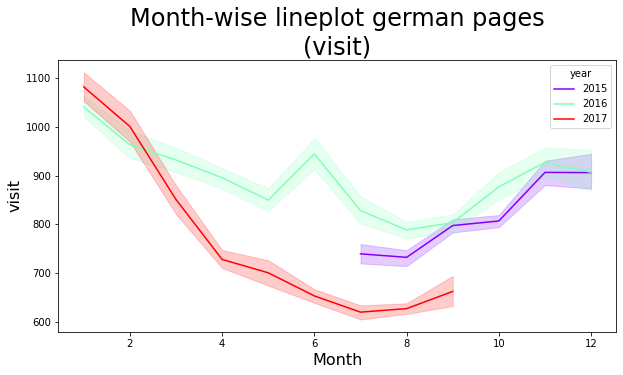

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot german pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

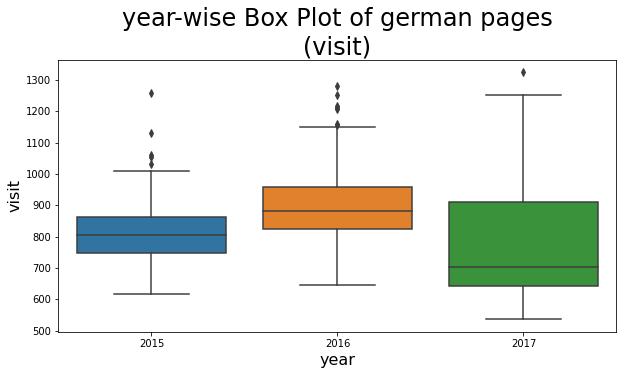

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of german pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2017 has the highest and lowest visit in german pages.

Text(0, 0.5, 'visit')

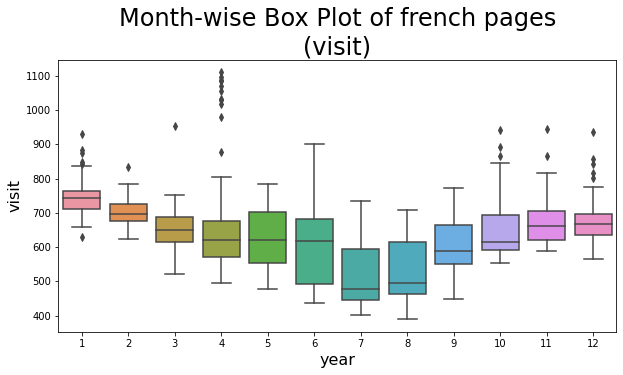

In [ ]:
df=everyday_mean['fr']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of french pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.june has the highest avarage page visit where as august has the lowest avarage page visit.

2.april has some outliers.

Text(0, 0.5, 'visit')

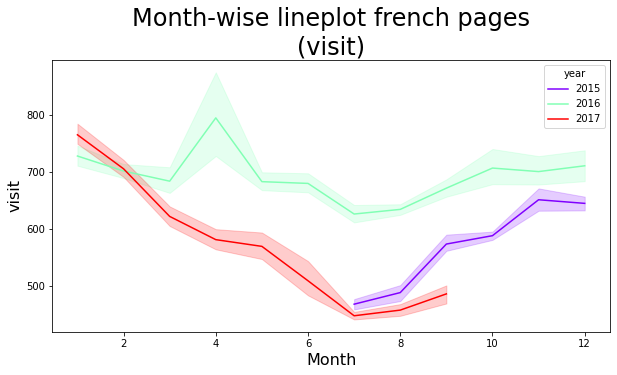

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot french pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

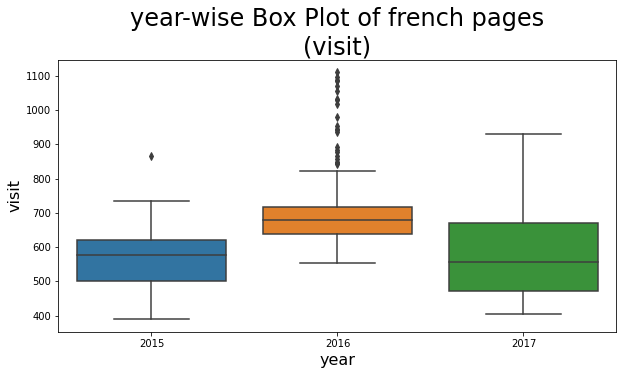

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of french pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2017 has the highest and lowest traffic and 2016 has all the outliers.

Text(0, 0.5, 'visit')

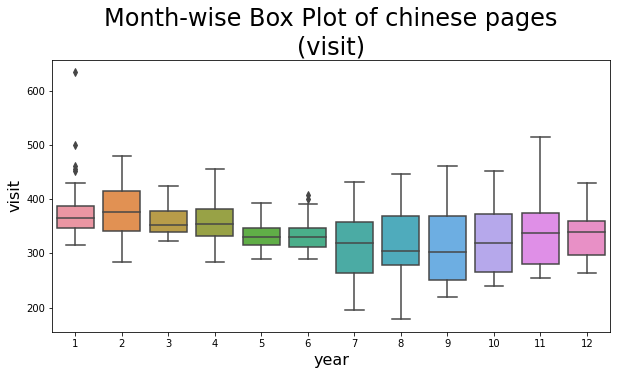

In [ ]:
df=everyday_mean['zh']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of chinese pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.november has the highest avarage page visit and august has the lowest avarage page visit.

Text(0, 0.5, 'visit')

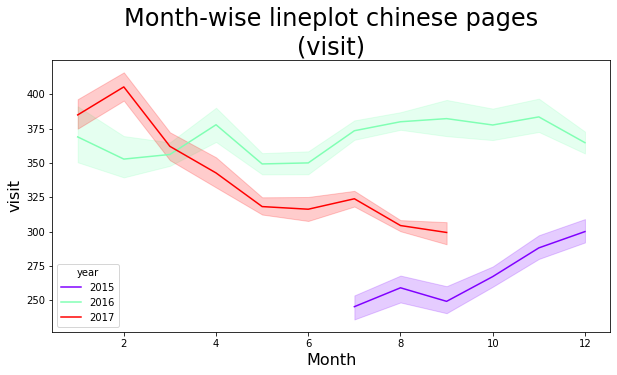

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot chinese pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

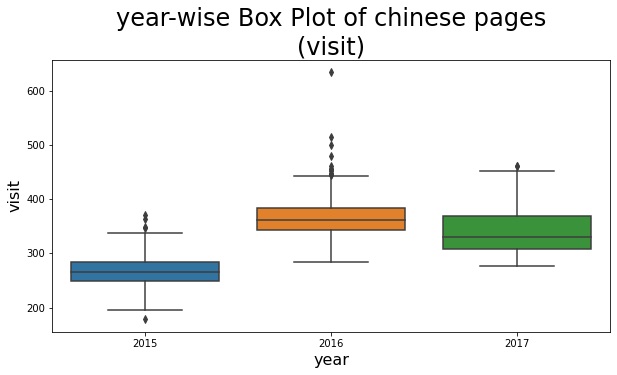

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of chinese pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2017 has the highest and lowest avarage page visit.

Text(0, 0.5, 'visit')

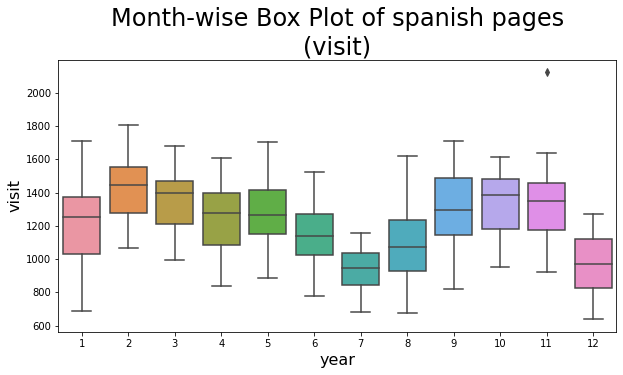

In [ ]:
df=everyday_mean['es']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of spanish pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.february has the highest avarage page visit and december has the lowest avarage page visit,

Text(0, 0.5, 'visit')

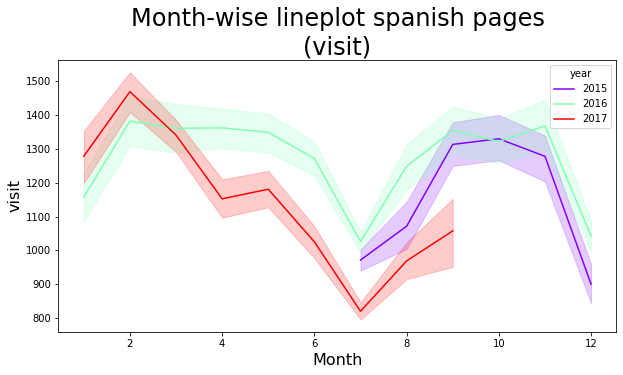

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot spanish pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

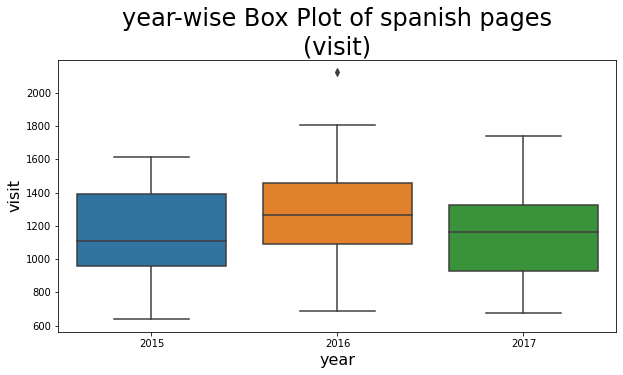

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of spanish pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2016 has thr highest avarage page visit and 2015 has the lowest avarage page visit.

Text(0, 0.5, 'visit')

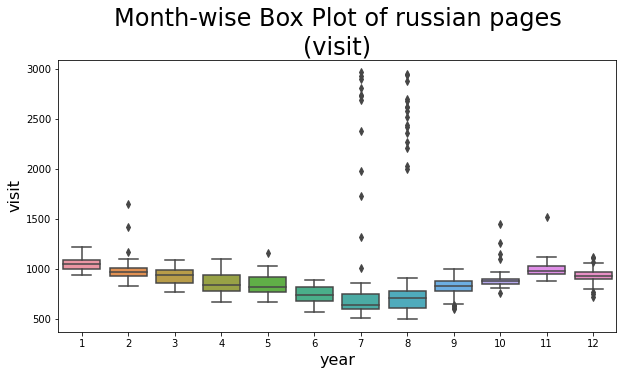

In [ ]:
df=everyday_mean['ru']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of russian pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.january has the highest avarage page visit and august has the lowest avarage page visit.

2.july and august has some unexpected spike in page visit.

Text(0, 0.5, 'visit')

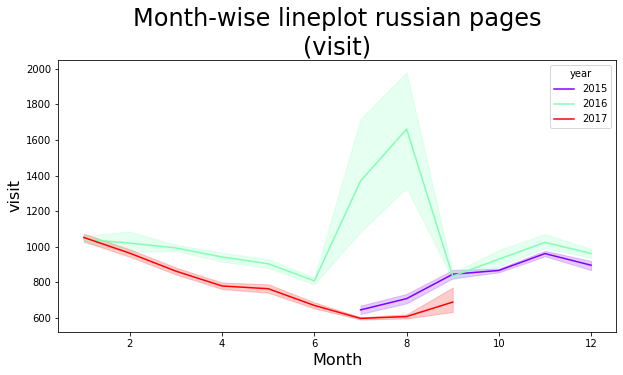

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot russian pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

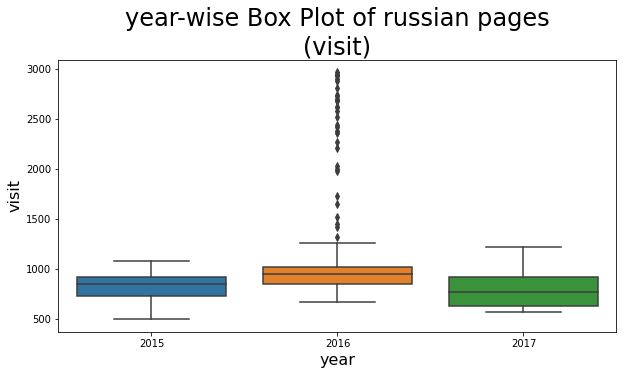

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of russian pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2016 has the highest avarage page visit and 2015 has the lowest avarage page visit.

Text(0, 0.5, 'visit')

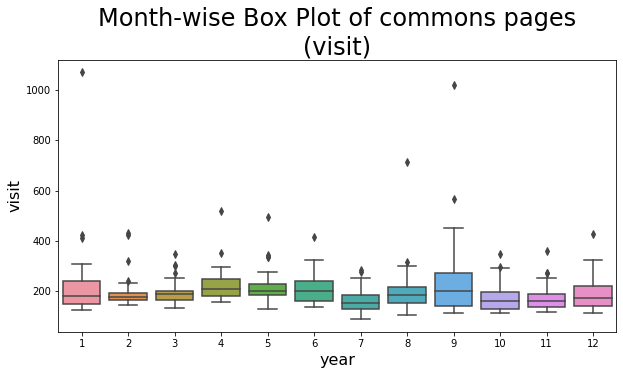

In [ ]:
df=everyday_mean['commons']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of commons pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.sepetember has the highest avarage page visit and july has the lowest avarage page visit.

Text(0, 0.5, 'visit')

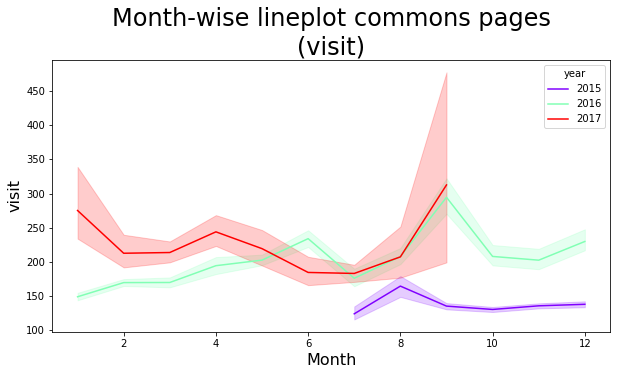

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot commons pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

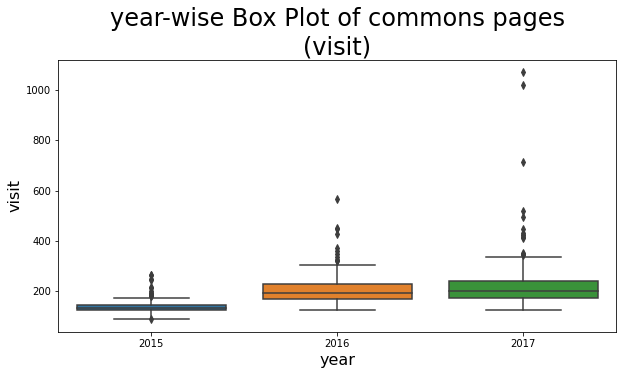

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of commons pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2017 has the highest avarage page visit and 2015 has the lowest avarage page visit.

Text(0, 0.5, 'visit')

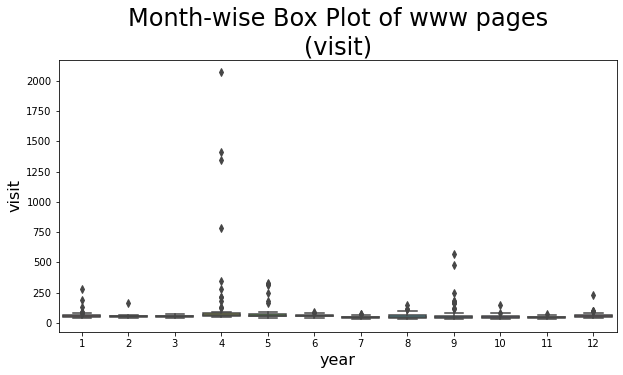

In [ ]:
df=everyday_mean['www']
df=pd.DataFrame(df).reset_index()
df.columns=["date","visit"]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['month'], df["visit"])
plt.title('Month-wise Box Plot of www pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.all the www pages has low avarage page visit every month. out of all august has slightly high avarage page visit.

Text(0, 0.5, 'visit')

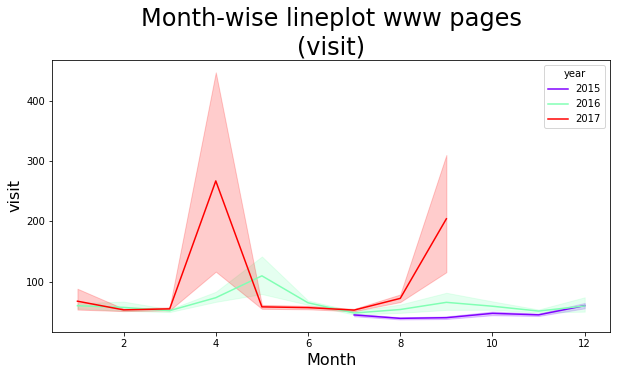

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.lineplot(df['month'], df["visit"],hue=df["year"],palette="rainbow")
plt.title('Month-wise lineplot www pages\n(visit)', fontsize = 24)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

Text(0, 0.5, 'visit')

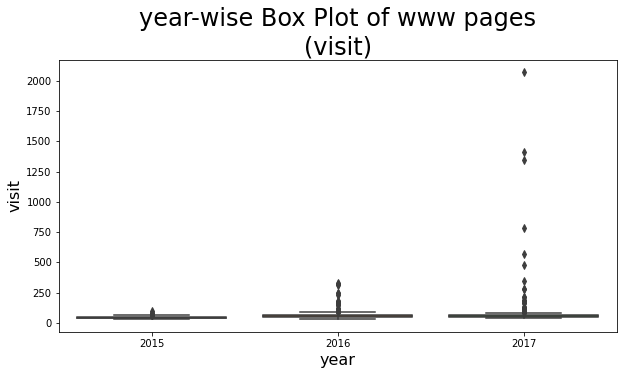

In [ ]:
ax=plt.figure(figsize=(10,5))
sns.boxplot(df['year'], df["visit"])
plt.title('year-wise Box Plot of www pages\n(visit)', fontsize = 24)
plt.xlabel('year', fontsize = 16)
plt.ylabel('visit', fontsize = 16)

**obervations:-**
1.2016 has hihest avarage page view.

2.there was some spikes seen 2017.

<h1>stationarity check</h1>

In [ ]:
stationary=0
for i in tqdm(range(1000)):  
  idx=randint(0,145000)
  t=data.iloc[idx,1:].values
  result = adfuller(t)
  if result[1]<0.05:
    stationary=stationary+1
print("number of stationary time series are ",stationary)

100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]

number of stationary time series are  888


**obervations:-**
1.testing all 145k time series is time consuming.so after taking a random sample from the whole dataset more than 88% time series are found to be stationary

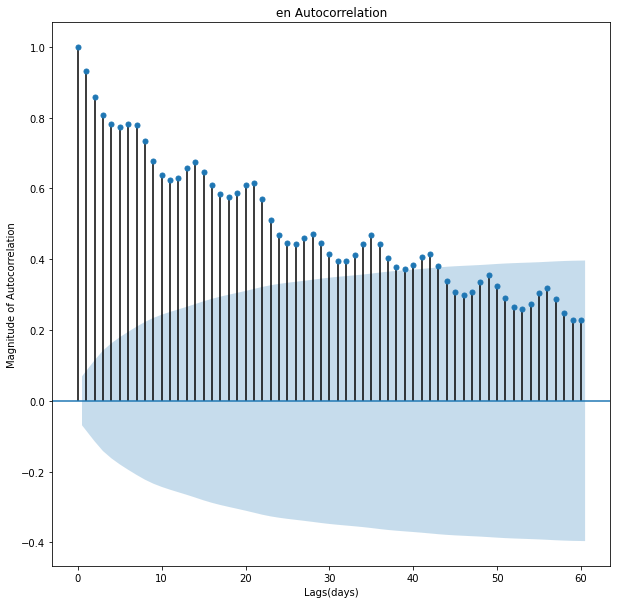

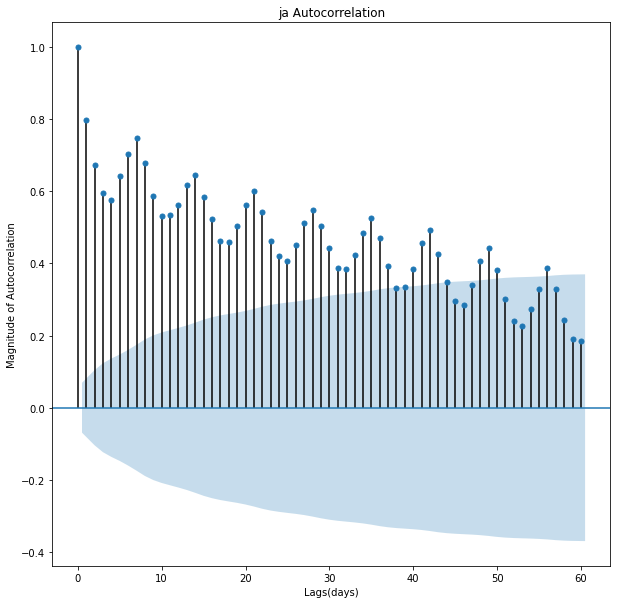

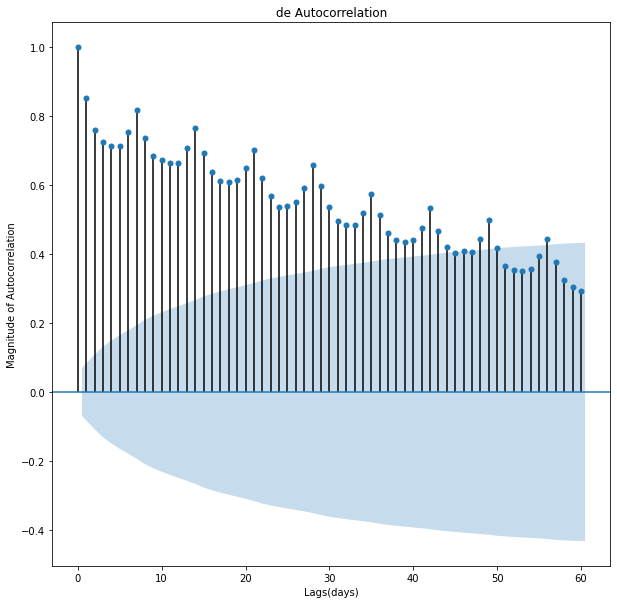

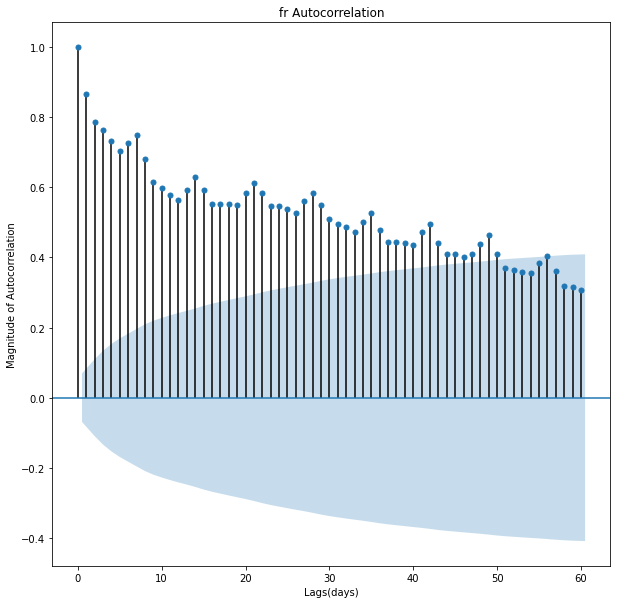

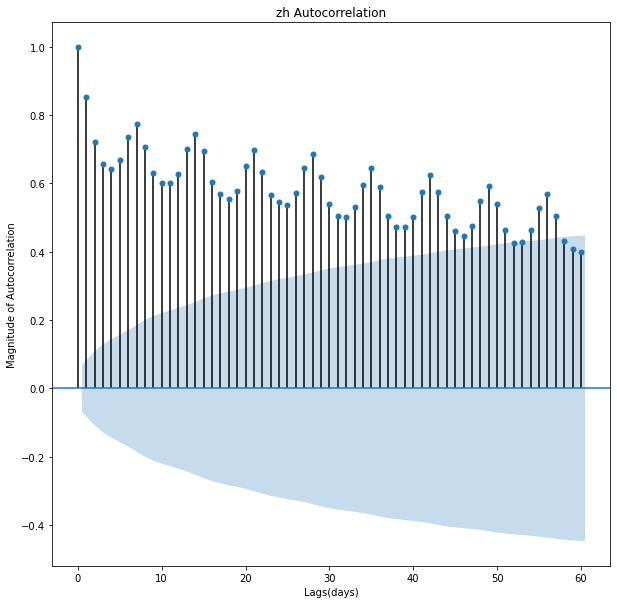

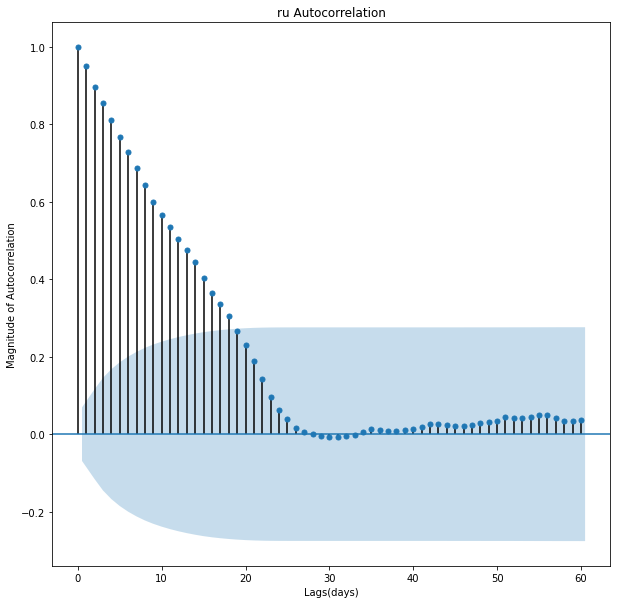

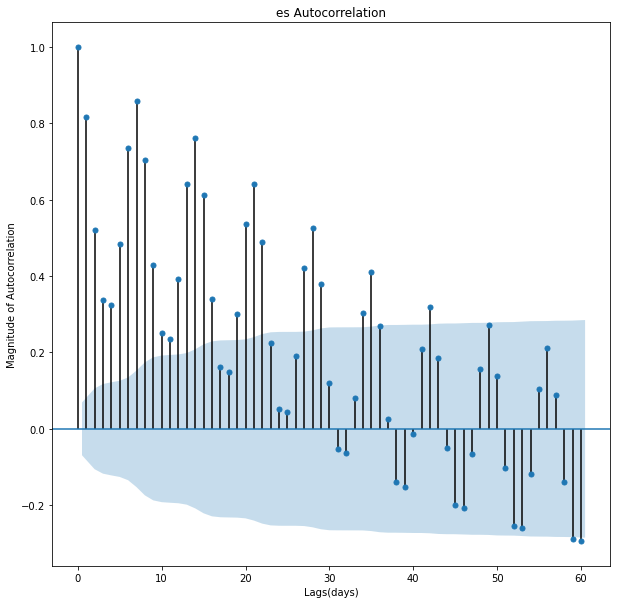

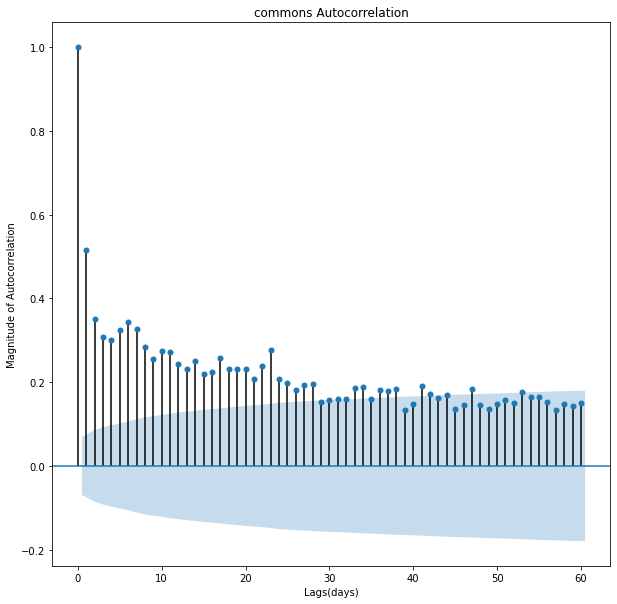

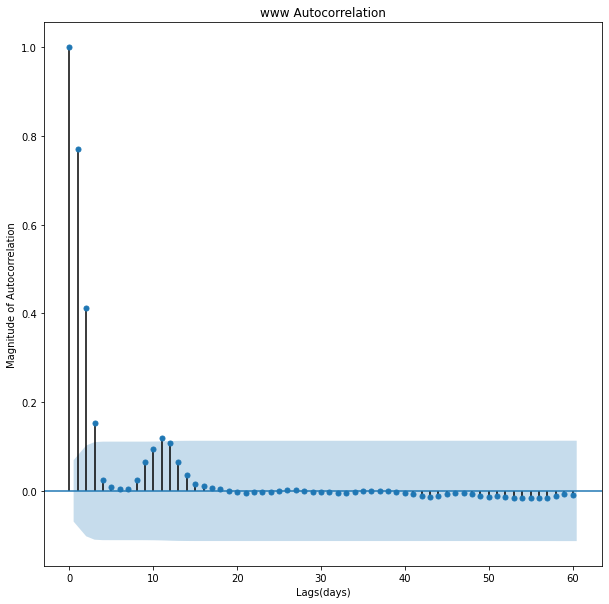

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl
for i in everyday_mean:  
  mpl.rc("figure", figsize=(10,10))
  x=plot_acf(everyday_mean[i],lags=60,title=i+" "+'Autocorrelation')
  plt.xlabel('Lags(days)')
  plt.ylabel('Magnitude of Autocorrelation')
  plt.show()

1.form this auto corelation plots it can be obsereved that lag day7 has high corelation in most of the langauge pages.

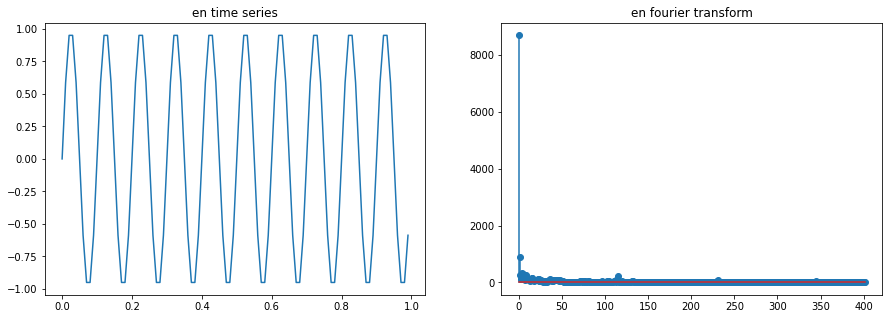

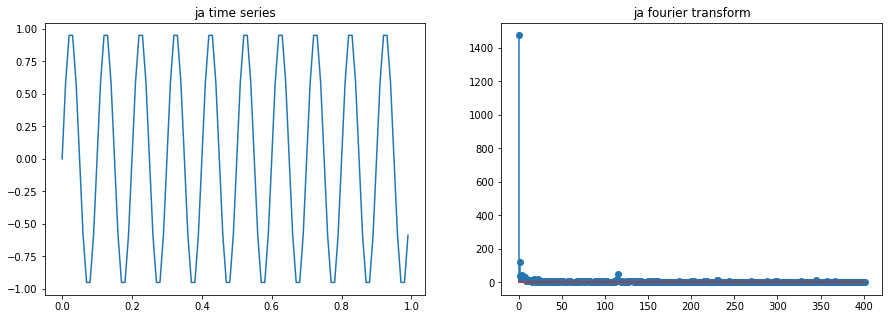

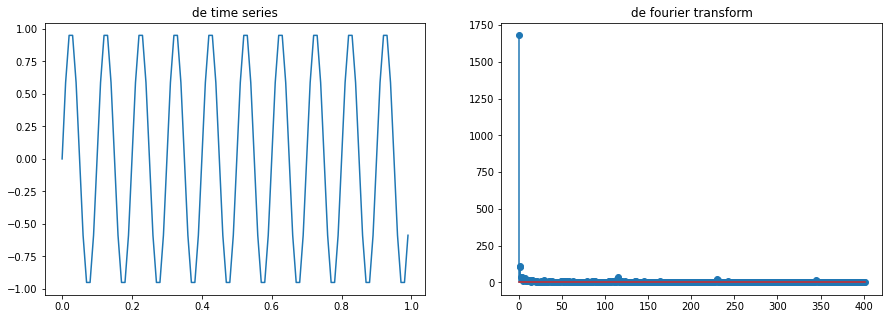

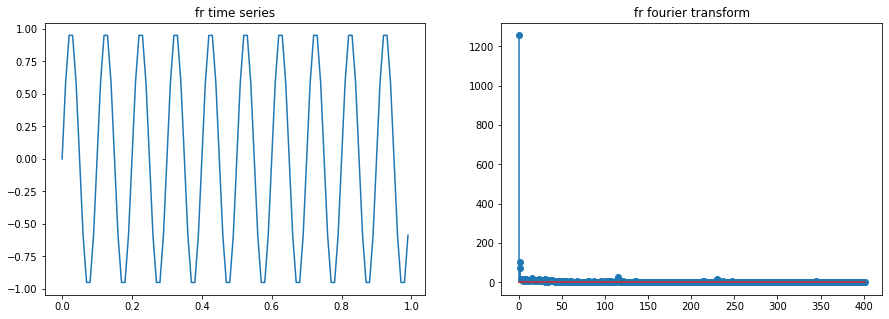

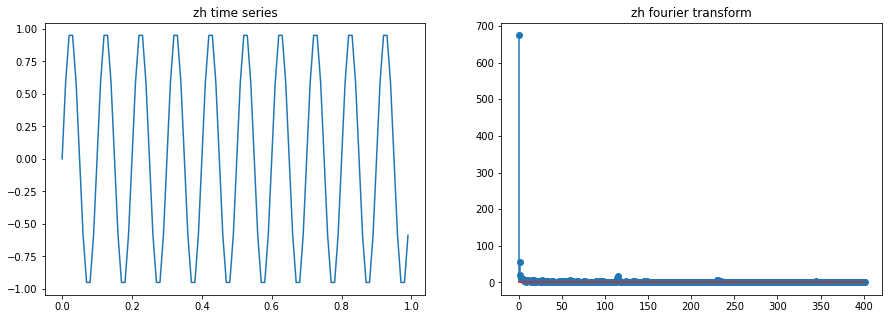

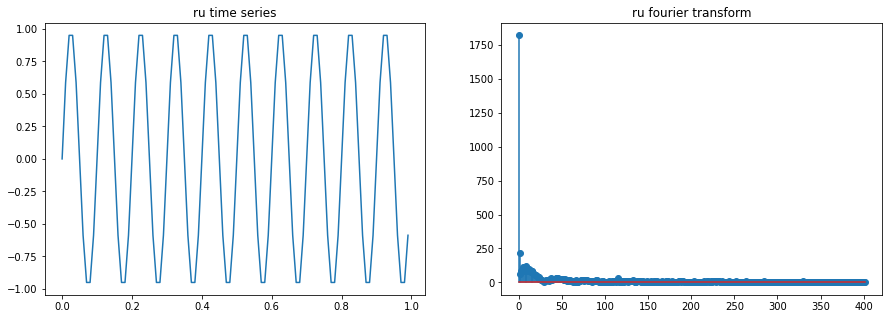

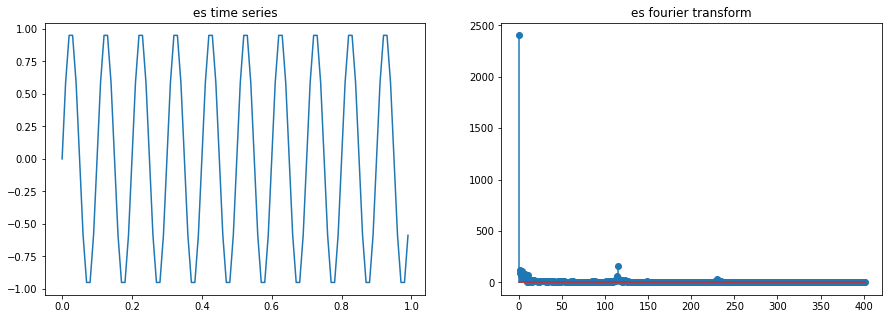

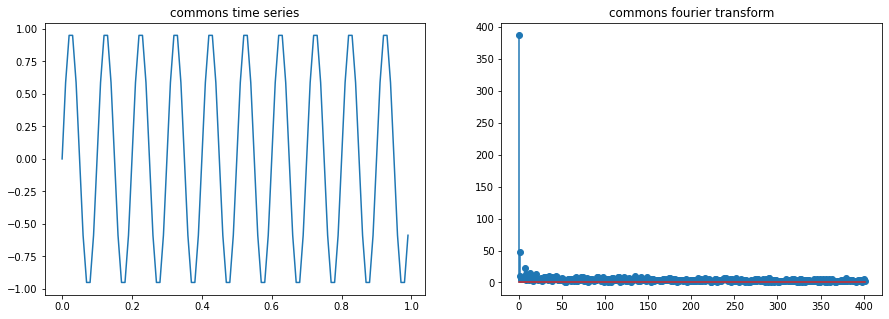

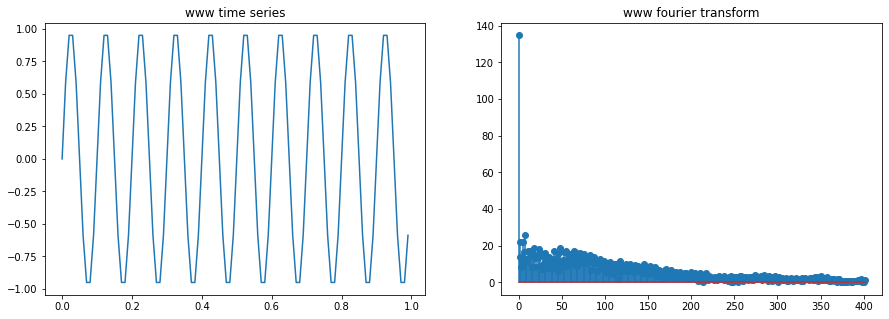

In [ ]:
from scipy import fftpack
for i in everyday_mean:
  y_fft = fftpack.fft(np.array(everyday_mean[i]))
  fr =np.linspace(0,803//2,803//2)
  y_m = 2/803 * abs(y_fft[0:np.size(fr)])
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  ax[0].plot(t, y)    # plot time series
  ax[0].title.set_text(i+" "+'time series')
  ax[1].stem(fr, y_m) # plot freq domain
  ax[1].title.set_text(i+" "+'fourier transform')

1.form this fourier tansforamtions we can conclude the there are some peak values in 120 days ,230 days and 340 days for all the language except russian and media page.

In [ ]:
med=[]
for i in range(len(data["Page"])):
  med.append(np.median(data.iloc[i].values[1:]))

In [ ]:
x=[80,85,90,95,100]
for i in x:
  print('{}th percentile of part1 is : '.format(i),np.percentile(med,i))

80th percentile of part1 is :  676.0
85th percentile of part1 is :  916.0
90th percentile of part1 is :  1338.0
95th percentile of part1 is :  2346.0
100th percentile of part1 is :  19440903.0


In [ ]:
x=[90,92,94,96,98,100]
for i in x:
  print('{}th percentile of part1 is : '.format(i),np.percentile(med,i))

90th percentile of part1 is :  1338.0
92th percentile of part1 is :  1614.0
94th percentile of part1 is :  2029.0
96th percentile of part1 is :  2769.0
98th percentile of part1 is :  4434.760000000009
100th percentile of part1 is :  19440903.0


In [ ]:
x=[99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in x:
  print('{}th percentile of part1 is : '.format(i),np.percentile(med,i))


99.1th percentile of part1 is :  6856.88400000002
99.2th percentile of part1 is :  7319.023999999918
99.3th percentile of part1 is :  7894.565999999992
99.4th percentile of part1 is :  8493.256000000052
99.5th percentile of part1 is :  9241.830000000016
99.6th percentile of part1 is :  10110.760000000038
99.7th percentile of part1 is :  11625.954000000143
99.8th percentile of part1 is :  14077.535999999614
99.9th percentile of part1 is :  20221.924000002327
100th percentile of part1 is :  19440903.0


In [ ]:
col=data.columns
for i in range(data.shape[0]):
    temp=data.iloc[i].values[1:]
    thres=np.percentile(temp,99.9)
    med=np.median(temp)
    for j in col[1:]:
        if(data.at[i,j]>thres):
            data.at[i,j]=med

In [ ]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0
